In [1]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import geopandas
import shapely
import cmocean
import pandas
import joblib

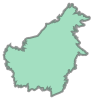

In [2]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union
borneo_main_geom = borneo_gdf_union.geoms[15]
list(borneo_gdf_union.geoms)[15]

In [3]:
#filename = '/Users/baird/Dropbox/_data_observations/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4-10.2018-05-31T17-55-21ZN.hdf'
file_dir = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/'

In [4]:
#file_list = sorted(glob.glob(file_dir+'/*.hdf'))
file_list = sorted(numpy.load('./borneo_land_mass_intersection_files_ALL.npy'))

In [5]:
# ===== open file, pull out specific data set
gdal_file = gdal.Open(file_list[0])
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter

In [6]:
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_tbc_data = gdal_tbc_ds.ReadAsArray()

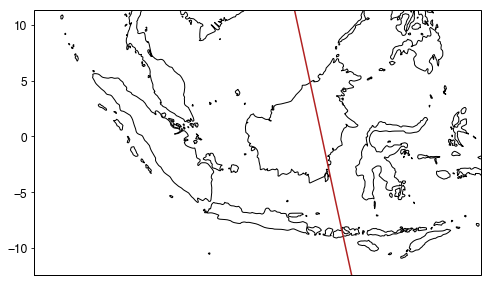

In [7]:
ds = xarray.open_dataset(file_list[0])

lat = ds['Latitude'].isel(fakeDim3=0).values
lon = ds['Longitude'].isel(fakeDim5=0).values


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

plot multiple at once

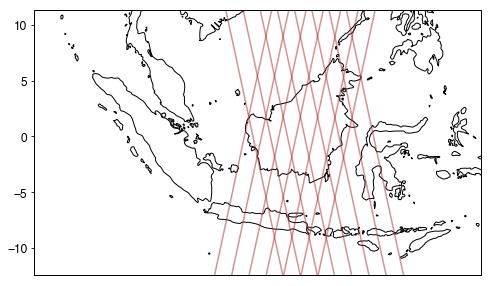

In [8]:
ds = xarray.open_dataset(file_list[0])

#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

# get the distinct ones
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,17,18]:
#for file in file_list[0,1,2,3,4,5]:
    file = file_list[i]
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].isel(fakeDim3=1).values
    lon = ds['Longitude'].isel(fakeDim5=1).values
    ax.plot(lon,lat,c='firebrick',alpha=0.5)
    ds.close()

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

In [9]:
distinct_track_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,17,18]

# Parallelize this

In [10]:
# define function to search whether the paths intersect
# faster to have borneo_main_geom already defined

def are_the_tracks_mostly_the_same(f_index, f_base_index, base_track_geom_buffer):
    '''
    Requires:
    base_track_geom_buffer,
    geometry_of_interest
    '''
    
    track_geom_list = []
    file_equivalent_list = []
    track_geom_cropped_list = []
    
    if f_index==f_base_index:
        print(file_list[f_base_index])
        pass
    
    else:
        ds = xarray.open_dataset(file_list[f_index])
        lat = ds['Latitude'].isel(fakeDim3=1).values
        lon = ds['Longitude'].isel(fakeDim5=1).values
        ds.close()

        track_geom_temporary = shapely.geometry.LineString(zip(lon,lat))
        track_geom_cropped = track_geom_temporary.intersection(geometry_of_interest)

        #if track_geom_borneo.intersects(base_track_geom_buffer):
        if base_track_geom_buffer.contains(track_geom_cropped):
            track_geom_list.append(track_geom_temporary)
            file_equivalent_list.append(file_list[f_index])
            track_geom_cropped_list.append(track_geom_cropped)

    return file_equivalent_list#, track_geom_list

In [13]:
joblib_result_list = []

for fbi in distinct_track_indices:
    
    print(fbi)
    f_base_index=fbi
    base_track_filename = file_list[f_base_index]
    base_track_ds = xarray.open_dataset(base_track_filename)
    lat = base_track_ds['Latitude'].isel(fakeDim3=1).values
    lon = base_track_ds['Longitude'].isel(fakeDim5=1).values
    base_track_ds.close()
    base_track_geom = shapely.geometry.LineString(zip(lon,lat))
    base_track_geom_buffer = base_track_geom.buffer(0.25)
    
    geometry_of_interest = borneo_main_geom
    
    joblib_result = [[base_track_filename]] + joblib.Parallel(n_jobs=30, verbose=1)\
    (joblib.delayed(are_the_tracks_mostly_the_same)(f,fbi,base_track_geom_buffer) for f in range(file_list.__len__()))

#     joblib_result = [[base_track_filename]] + joblib.Parallel(n_jobs=30, verbose=10)\
#     (joblib.delayed(are_the_tracks_mostly_the_same)(f,fbi,base_track_geom_buffer) for f in range(100))

    joblib_result_list.append([item for sublist in joblib_result for item in sublist])
    joblib_result_array = numpy.array(joblib_result_list[-1])
    saveas_name = base_track_filename.split('/')[-1][:-4]
    numpy.save(saveas_name + '_and_equivalent_tracks_over_borneo.npy', joblib_result_array)

0


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:   18.4s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   30.8s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   47.8s
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.7min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  3.1min finished


1


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.3s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


2


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.3s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


3


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.2s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.4s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


4


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.3s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.3s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.2s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


5


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   41.9s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:  1.1min
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.5min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  3.0min finished


6


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.4s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


7


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.6s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.2s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


8


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    7.6s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.1s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.2s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.6s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


9


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.3s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.4s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.2s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.2s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.7s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:  1.1min
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.5min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  3.0min finished


11


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.7s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.5s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


12


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.3s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


17


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    7.9s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.4s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.5s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


18


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   20.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   37.6s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   59.3s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  2.6min
[Parallel(n_jobs=30)]: Done 3591 out of 3591 | elapsed:  2.9min finished


# testing

In [ ]:
track_geom_list = []
file_equivalent_list = []
track_geom_cropped_list = []

for f in range(100):

    f_base_index=14
    f_index=f

    base_track_filename = file_list[distinct_track_indices[f_base_index]]
    base_track_ds = xarray.open_dataset(base_track_filename)
    lat = base_track_ds['Latitude'].isel(fakeDim3=0).values
    lon = base_track_ds['Longitude'].isel(fakeDim5=0).values
    base_track_ds.close()
    base_track_geom = shapely.geometry.LineString(zip(lon,lat))
    base_track_geom_buffer = base_track_geom.buffer(1)

    geometry_of_interest = borneo_main_geom

    if f_index==f_base_index:
        print(file_list[f_base_index])
        pass

    else:
        ds = xarray.open_dataset(file_list[f_index])
        lat = ds['Latitude'].isel(fakeDim3=1).values
        lon = ds['Longitude'].isel(fakeDim5=1).values
        ds.close()

        track_geom_temporary = shapely.geometry.LineString(zip(lon,lat))
        track_geom_cropped = track_geom_temporary.intersection(geometry_of_interest)

        #if track_geom_borneo.intersects(base_track_geom_buffer):
        if base_track_geom_buffer.contains(track_geom_cropped):
            print('TRUE')
            track_geom_list.append(track_geom_temporary)
            track_geom_cropped_list.append(track_geom_cropped)
            file_equivalent_list.append(file_list[f_index])

#    return file_equivalent_list#, track_geom_list

In [ ]:
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

# for file in file_equivalent_list:
#     ds = xarray.open_dataset(file)
#     lat = ds['Latitude'].sel(fakeDim3=1).values
#     lon = ds['Longitude'].sel(fakeDim5=1).values
#     ax.plot(lon,lat,c='firebrick')
#     ds.close()
    
#     if file==file_equivalent_list[0]:
#         base_track_geom = shapely.geometry.LineString(zip(lon,lat))

base_track_geom_buffer = base_track_geom.buffer(0.25)
ax.add_geometries([base_track_geom_buffer], crs=cartopy.crs.PlateCarree(), facecolor='firebrick', alpha=0.5)

ax.add_geometries(track_geom_cropped_list[5], crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick', alpha=1)

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

In [ ]:
joblib_result_list[0]

In [ ]:
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

for file in joblib_result_list[0]:
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].sel(fakeDim3=1).values
    lon = ds['Longitude'].sel(fakeDim5=1).values

    base_track_geom = shapely.geometry.LineString(zip(lon,lat))
    ax.add_geometries([base_track_geom], crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick', alpha=1)

#base_track_geom_buffer = base_track_geom.buffer(0.25)
#ax.add_geometries([base_track_geom_buffer], crs=cartopy.crs.PlateCarree(), facecolor='firebrick', alpha=0.5)

#ax.add_geometries(track_geom_cropped_list[5], crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick', alpha=1)

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

In [ ]:
joblib_result_list

In [ ]:
joblib_result_list

In [ ]:
joblib_result_list

In [ ]:
joblib_result_list

    50 processes
    n_jobs = 5:  4.6s
    n_jobs = 8:  4.6s
    n_jobs = 9:  4.0s
    n_jobs = 10:  3.6-3.9s
    n_jobs = 11:  3.0-3.8s
    n_jobs = 12:  4.3s
    n_jobs = 20:  3.5ish s

In [ ]:
joblib_result_list[0].__len__()

In [ ]:
[joblib_result_list.count(i) for i in joblib_result_list]

In [ ]:
joblib_result_list_TOTAL = joblib_result_list_copy+joblib_result_list

In [ ]:
sum([i.__len__() for i in joblib_result_list_TOTAL])

In [ ]:
joblist_result_flatten = [i for sublist in joblib_result_list_TOTAL for i in sublist]

In [ ]:
[joblist_result_flatten.count(i) for i in joblist_result_flatten]

In [ ]:
file_list.__len__()

In [ ]:
joblib_result_list_copy = joblib_result_list.copy()

In [ ]:
a = [i.__len__() for i in joblib_result_list_copy]
sum(a)

In [ ]:
file_list.__len__()

In [ ]:
(3591-3236)

In [ ]:
flatten_result = [item for sublist in joblib_result for item in sublist]
#numpy.save('borneo_land_mass_intersection_files_ALL.npy', flatten_result)

In [ ]:
flatten_result